In [1]:
%pylab inline
import h5py
import grispy as gsp
import programas

Populating the interactive namespace from numpy and matplotlib


In [2]:
## voids position

v = np.loadtxt('sphvds_raul-0.8.dat')
centres = v[:,2:5]

In [56]:
## bias field

field = np.load('/mnt/projects/bias_mock/rhodm_eul.npy')

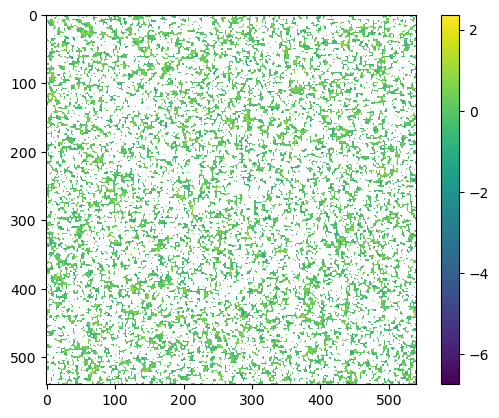

In [51]:
plt.imshow(np.log10(field[:,:,0]))
plt.colorbar()

In [5]:
lbox = 1440

In [6]:
def periodicidad(nbin,bines):
    
    if (nbin==0):
            bin_out = bines
    elif (nbin==bines + 1): 
            bin_out = 1
    elif (nbin<0):
            bin_out = bines + nbin
    elif (nbin>bines):
            bin_out = nbin - bines
    else :
            bin_out = nbin
    
    return bin_out    

In [7]:
bines = 10
rmin = 0.01
rmax = 3
bineado = np.logspace(np.log10(rmin),np.log10(rmax),bines)

In [8]:
bineado[9]

3.0

In [9]:
def generar_bines(binx, biny, binz, nbines):
    
    bines_alrededor = []
    
    for i in range(binx - nbines, binx + nbines + 1):
        
        ibin = periodicidad(i,nbines)
        
        for j in range(biny - nbines, biny + nbines + 1):
        
            jbin = periodicidad(j,nbines)
        
            for k in range(binz - nbines, binz + nbines + 1):
            
                kbin = periodicidad(k,nbines)
            
            bines_alrededor.append((ibin, jbin, kbin))
    
    return bines_alrededor

# Ejemplo de uso
binx = 20
biny = 10
binz = 34
nbines = 1
resultado = generar_bines(binx, biny, binz, 3)
print(resultado)

[(14, 4, 34), (14, 5, 34), (14, 6, 34), (14, 7, 34), (14, 8, 34), (14, 9, 34), (14, 10, 34), (15, 4, 34), (15, 5, 34), (15, 6, 34), (15, 7, 34), (15, 8, 34), (15, 9, 34), (15, 10, 34), (16, 4, 34), (16, 5, 34), (16, 6, 34), (16, 7, 34), (16, 8, 34), (16, 9, 34), (16, 10, 34), (17, 4, 34), (17, 5, 34), (17, 6, 34), (17, 7, 34), (17, 8, 34), (17, 9, 34), (17, 10, 34), (18, 4, 34), (18, 5, 34), (18, 6, 34), (18, 7, 34), (18, 8, 34), (18, 9, 34), (18, 10, 34), (19, 4, 34), (19, 5, 34), (19, 6, 34), (19, 7, 34), (19, 8, 34), (19, 9, 34), (19, 10, 34), (20, 4, 34), (20, 5, 34), (20, 6, 34), (20, 7, 34), (20, 8, 34), (20, 9, 34), (20, 10, 34)]


In [14]:
def distance_correction_periodicity(distance,lbox):
    if (distance > lbox/2):
        distance = abs(distance-lbox)
        
    return distance

In [36]:
def profile_bias(x,y,z,rvoid,field,bines,bineado,lbox,profile = None, particles = None):
    
    if profile == None:
        profile = np.zeros(bines )
        particles = np.zeros(bines )
        
    # tomo el rango de distancias del perfil (en unidades de rvoid)
    rmin = bineado[0]
    maxbin = bineado.shape[0] - 1
    rmax = bineado[maxbin]
    #abin = (np.log10(rmax)-np.log10(rmin))/bines
    abin = (rmax-rmin)/bines
    
    # fbines es el numero de bines del field (ej: 540). 
    # Calculamos entonces el tamaño de cada uno de los bines
    fbines = field.shape[0]
    bin_size = lbox/fbines
    
    # cuantas capas de bines tengo que recorrer.
    nbines = int(rvoid*rmax/bin_size)
    #print(rvoid,rmax,bin_size,nbines)
    # bines (en el field) donde esta el centro del void
    binx0 = int(x/bin_size)
    biny0 = int(y/bin_size)
    binz0 = int(z/bin_size)
    
    seleccion_bines = generar_bines(binx0, biny0, binz0, nbines)
    bin_number = len(seleccion_bines)
    
    for i in range(bin_number):
        
        binx = seleccion_bines[i][0]
        biny = seleccion_bines[i][1]
        binz = seleccion_bines[i][2]
    
        posx = binx*bin_size
        posy = biny*bin_size
        posz = binz*bin_size
        
        bias_value = field[binx,biny,binz]
        
        dx = abs(posx-x)
        dx = distance_correction_periodicity(dx,lbox)
        dy = abs(posy-y)
        dy = distance_correction_periodicity(dy,lbox)
        dz = abs(posz-z)
        dz = distance_correction_periodicity(dz,lbox)
        
        d = np.sqrt(dx**2 + dy**2 + dz**2)
        d_normalize = d/rvoid
        #nbin = int(np.log10(d_normalize)/abin)
        nbin = int(d_normalize/abin)
        #print(d,d_normalize,nbin,bines)
        
        if d_normalize < rmax:
            profile[nbin] = profile[nbin] + bias_value
            particles[nbin] = particles[nbin] + 1
        
    return profile, particles    

In [40]:
x = v[10,2]
y = v[10,3]
z = v[10,4]
rvoid = v[10,1]
bines = 8
rmin = 0
rmax = 3
#bineado = np.logspace(np.log10(rmin),np.log10(rmax),bines)
bineado = np.linspace(rmin,rmax,bines)

In [52]:
%%time

perfil, particulas = profile_bias(x,y,z,rvoid,field,bines,bineado,lbox)

CPU times: user 39.2 ms, sys: 907 µs, total: 40.1 ms
Wall time: 62.5 ms


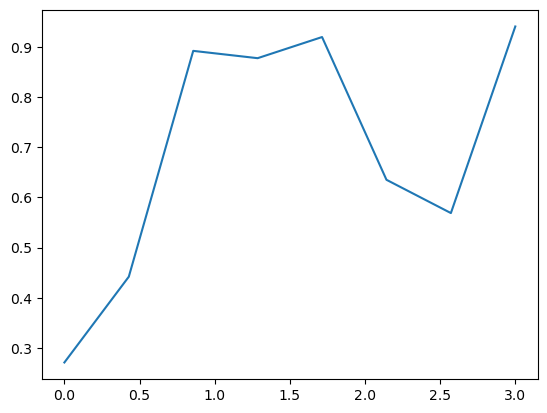

In [42]:
plt.plot(bineado,perfil/particulas)

(0.0, 3.0)

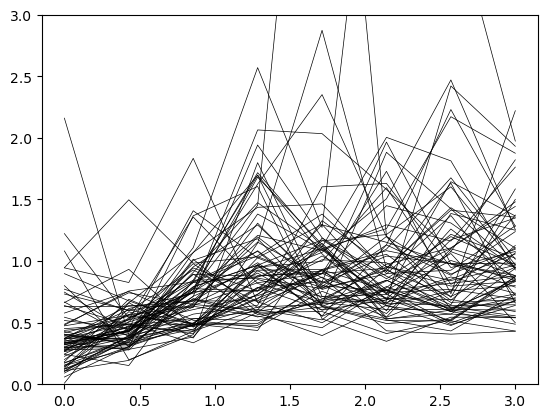

In [57]:
import warnings

warnings.filterwarnings("ignore")

for i in range(100):
    x = v[i,2]
    y = v[i,3]
    z = v[i,4]
    rvoid = v[i,1]
    perfil, particulas = profile_bias(x,y,z,rvoid,field,bines,bineado,lbox)
    plt.plot(bineado,perfil/particulas,lw=.5,color='black')
    
plt.ylim(0,3)

In [82]:
bineado

array([0.01      , 0.01228625, 0.0150952 , 0.01854635, 0.02278651,
       0.02799609, 0.03439671, 0.04226066, 0.05192252, 0.06379333,
       0.0783781 , 0.09629732, 0.11831333, 0.14536276, 0.17859637,
       0.21942803, 0.26959484, 0.33123106, 0.40695888, 0.5       ])